<a href="https://colab.research.google.com/github/adv555/DataScience/blob/main/Keras/vgg16_fashion_mnist_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install visualkeras

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras import layers
from keras.utils import to_categorical
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from PIL import Image
import visualkeras

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
plt.figure(figsize=(10,10))
for i in range(5):
  plt.subplot(1,5, i+1)
  plt.imshow(x_train[i], cmap=plt.cm.binary)
  plt.xlabel(y_train[i])
  plt.xticks([])
  plt.yticks([])
plt.plot()

In [ ]:
x_train=np.dstack([x_train] * 3)
x_test=np.dstack([x_test]*3)
x_test = x_test.reshape(-1, 28,28,3)
x_train = x_train.reshape(-1, 28,28,3)
print(x_train.shape, x_test.shape)

(60000, 28, 28, 3) (10000, 28, 28, 3)


In [ ]:
def reshape_img(data, img_size):
  step = 0
  new_data = []
  for item in range(len(data)):
    image = Image.fromarray(data[step]).resize((img_size, img_size), Image.BILINEAR)
    image = np.asarray(image)
    new_data.append(image)
    step+=1
  new_data = np.array(new_data)
  return new_data
     

In [ ]:
x_train = reshape_img(x_train, 48)
x_test = reshape_img(x_test, 48)

In [ ]:
x_train = x_train / 255
x_test = x_test / 255

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
# Copyright 2023 Google Research. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""TF2 implementation of the Lion optimizer."""

import tensorflow.compat.v2 as tf


class Lion(tf.keras.optimizers.legacy.Optimizer):
  r"""Optimizer that implements the Lion algorithm."""

  def __init__(self,
               learning_rate=0.0001,
               beta_1=0.9,
               beta_2=0.99,
               wd=0,
               name='lion',
               **kwargs):
    """Construct a new Lion optimizer."""

    super(Lion, self).__init__(name, **kwargs)
    self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
    self._set_hyper('beta_1', beta_1)
    self._set_hyper('beta_2', beta_2)
    self._set_hyper('wd', wd)

  def _create_slots(self, var_list):
    # Create slots for the first and second moments.
    # Separate for-loops to respect the ordering of slot variables from v1.
    for var in var_list:
      self.add_slot(var, 'm')

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(Lion, self)._prepare_local(var_device, var_dtype, apply_state)

    beta_1_t = tf.identity(self._get_hyper('beta_1', var_dtype))
    beta_2_t = tf.identity(self._get_hyper('beta_2', var_dtype))
    wd_t = tf.identity(self._get_hyper('wd', var_dtype))
    lr = apply_state[(var_device, var_dtype)]['lr_t']
    apply_state[(var_device, var_dtype)].update(
        dict(
            lr=lr,
            beta_1_t=beta_1_t,
            one_minus_beta_1_t=1 - beta_1_t,
            beta_2_t=beta_2_t,
            one_minus_beta_2_t=1 - beta_2_t,
            wd_t=wd_t))

  @tf.function(jit_compile=True)
  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype)) or
                    self._fallback_apply_state(var_device, var_dtype))

    m = self.get_slot(var, 'm')
    var_t = var.assign_sub(
        coefficients['lr_t'] *
        (tf.math.sign(m * coefficients['beta_1_t'] +
                      grad * coefficients['one_minus_beta_1_t']) +
         var * coefficients['wd_t']))
    with tf.control_dependencies([var_t]):
      m.assign(m * coefficients['beta_2_t'] +
               grad * coefficients['one_minus_beta_2_t'])

  @tf.function(jit_compile=True)
  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype)) or
                    self._fallback_apply_state(var_device, var_dtype))

    m = self.get_slot(var, 'm')
    m_t = m.assign(m * coefficients['beta_1_t'])
    m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
    m_t = m_t.scatter_add(tf.IndexedSlices(m_scaled_g_values, indices))
    var_t = var.assign_sub(coefficients['lr'] *
                           (tf.math.sign(m_t) + var * coefficients['wd_t']))

    with tf.control_dependencies([var_t]):
      m_t = m_t.scatter_add(tf.IndexedSlices(-m_scaled_g_values, indices))
      m_t = m_t.assign(m_t * coefficients['beta_2_t'] /
                       coefficients['beta_1_t'])
      m_scaled_g_values = grad * coefficients['one_minus_beta_2_t']
      m_t.scatter_add(tf.IndexedSlices(m_scaled_g_values, indices))

  def get_config(self):
    config = super(Lion, self).get_config()
    config.update({
        'learning_rate': self._serialize_hyperparameter('learning_rate'),
        'beta_1': self._serialize_hyperparameter('beta_1'),
        'beta_2': self._serialize_hyperparameter('beta_2'),
        'wd': self._serialize_hyperparameter('wd'),
    })
    return config

In [ ]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=[48, 48] + [3])
conv_base.trainable = True

model = Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(256, activation="relu"),
   layers.Dense(128, activation="relu"),
   layers.Dropout(0.5),
   layers.Dense(10, activation="sigmoid"),
#    layers.Dense(10, activation="softmax"),
])

# lion_optimizer = Lion()

model.compile(
    # optimizer=lion_optimizer,
    optimizer='Adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

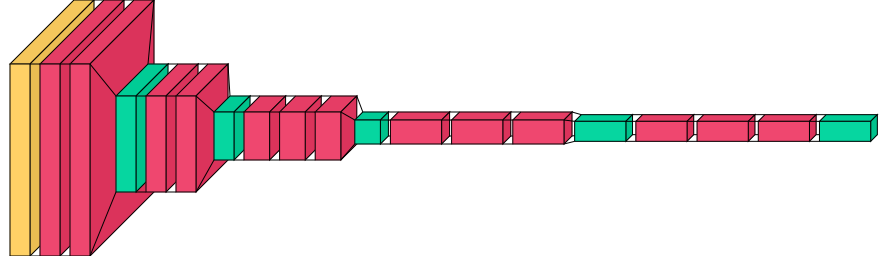

In [ ]:
visualkeras.layered_view(conv_base)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 14,880,202
Trainable params: 14,880,202
No

In [ ]:
visualkeras.layered_view(model)

In [ ]:
set_trainable = False

for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
     

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 14,880,202
Trainable params: 7,244,938
Non

In [ ]:
x_train.shape

(60000, 48, 48, 3)

In [ ]:
x_val = x_train[:30000]
partial_x_train = x_train[30000:]

y_val = y_train[:30000]
partial_y_train = y_train[30000:]

In [ ]:
history = model.fit(
    # x_train,
    # y_train,
    partial_x_train,
    partial_y_train,
    epochs=15,
    batch_size=64,
    validation_data=(x_val, y_val)
    # validation_data=(0.5)
)

In [ ]:
loss_test, acc_test = model.evaluate(x_test, y_test)
print(f'Loss Test: {loss_test}, Accuracy Test: {acc_test}')

313/313 [==============================] - 4s 13ms/step - loss: 0.3531 - accuracy: 0.8825
Loss Test: 0.3531361222267151, Accuracy Test: 0.8824999928474426


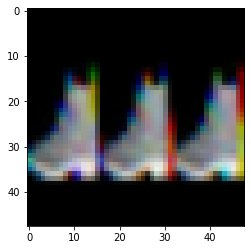

In [ ]:
plt.imshow(x_test[0].reshape(48, 48, 3), cmap=plt.cm.binary)
plt.show()

In [ ]:
x_test[0].shape

(48, 48, 3)

In [ ]:

image = x_test[0]
image = (np.expand_dims(image,0))
image.shape

(1, 48, 48, 3)

In [ ]:
predictions = model.predict(image)
predictions

1/1 [==============================] - 0s 492ms/step


array([[3.3341641e-06, 1.3995641e-07, 1.7831207e-08, 3.3748468e-06,
        5.9452008e-09, 5.9267271e-02, 2.8813312e-05, 9.8155516e-01,
        6.1519620e-07, 9.9925846e-01]], dtype=float32)

In [ ]:
prediction = predictions[0]
np.argmax(prediction)

9

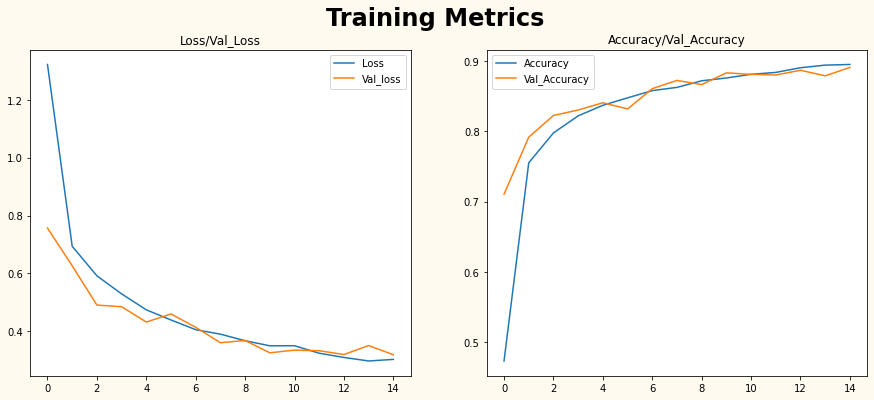

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Training Metrics', fontsize=24, fontweight='bold')
fig.set_facecolor('floralwhite')

axes[0].set_title('Loss/Val_Loss')
axes[0].plot(history.history['loss'], label='Loss')
axes[0].plot(history.history['val_loss'], label='Val_loss')
axes[0].legend()

axes[1].set_title('Accuracy/Val_Accuracy')
axes[1].plot(history.history['accuracy'], label='Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val_Accuracy')
axes[1].legend()

plt.show()

In [ ]:
x_test.shape

(10000, 48, 48, 3)

In [ ]:
pred = np.argmax(predictions)

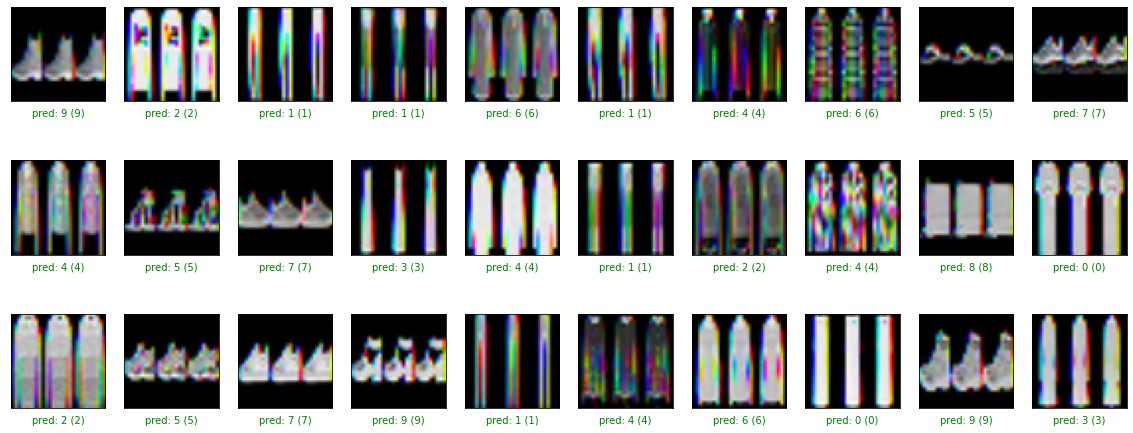

In [ ]:
plt.figure(figsize=(20,8))

for i in range(30):
    plt.subplot(3,10,i+1)
    plt.imshow(x_test[i].reshape(48,48,3), cmap="gray")
   
    pred_label = np.argmax(y_test[i])
    true_label = np.argmax(y_test[i])
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    plt.xlabel("pred: {} ({})".format(pred_label, true_label), color=color)
    plt.xticks([])
    plt.yticks([])
plt.show()